📌 Title: Customer Churn Analysis (EDA, Statistical Testing & ML)

- Business Problem
Customer churn directly impacts revenue and customer lifetime value.
This project analyzes customer behavior to identify key churn drivers and evaluate predictive models that can help prioritize high-risk customers for retention strategies.

🎯 Objective: To analyze customer churn patterns and identify key factors associated with customer attrition using exploratory data analysis, statistical tests, and machine learning models.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu
from scipy.sparse import hstack

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score,confusion_matrix
from sklearn.metrics import classification_report,RocCurveDisplay
from sklearn.metrics import precision_recall_curve,average_precision_score
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import warnings
warnings.filterwarnings("ignore")


sns.set(style="whitegrid")

In [2]:
df = pd.read_csv("data/telco_customer_churn.csv")

In [3]:
df.replace([""," ","?","NA","N/A","None"],np.nan,inplace=True)
before =df.shape[0]
df.dropna(inplace=True)
after =df.shape[0]

print(f"Dropped {(before-after)/before*100:.2f}% rows are due to missiing values")

Dropped 0.16% rows are due to missiing values


📊 Data Overview: This analysis uses a telecom customer dataset containing information on customer tenure, service usage, contract type, and billing. The project applies exploratory data analysis to understand churn behavior, statistical testing to examine relationships between categorical features and churn, and classification models to identify customers at higher risk of churning.

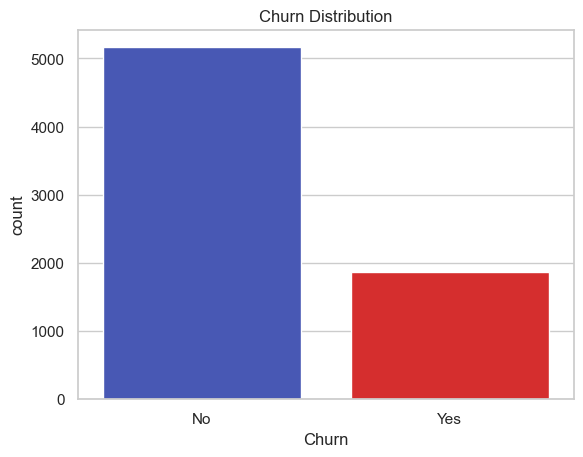

In [4]:
sns.countplot(x='Churn',data=df,hue='Churn',palette={'No': "#364BC6", 'Yes': "#F11212"})
plt.title('Churn Distribution')
plt.show()

- Insight: The dataset shows a higher proportion of non-churned customers, indicating class imbalance, which makes churn prediction more challenging and justifies the use of metrics beyond accuracy.

Customer Behavior Analysis

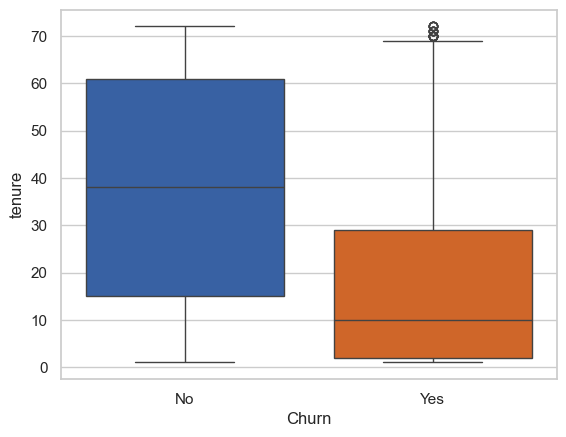

In [5]:
sns.boxplot(x='Churn',
            y='tenure',
            data=df,
            hue='Churn', 
            palette={'No': "#265DB5", 'Yes': "#EB5E0D"},
            legend=False)
plt.show()

- Insight: Churn is highest among customers with shorter tenure, highlighting the importance of onboarding and engagement during the early customer lifecycle.

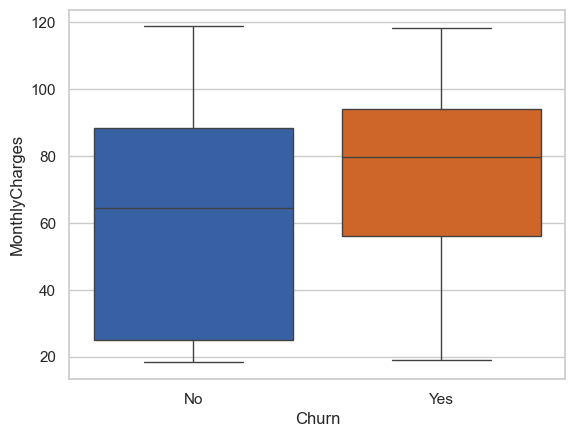

In [6]:
sns.boxplot(x='Churn',
            y='MonthlyCharges',
            data=df,
            hue='Churn', 
            palette={'No': "#265DB5", 'Yes': "#EB5E0D"},
            legend=False)
plt.show()

- Insight: Customers who churn tend to have higher median monthly charges and greater variability in pricing, suggesting that higher costs may increase dissatisfaction and churn risk.

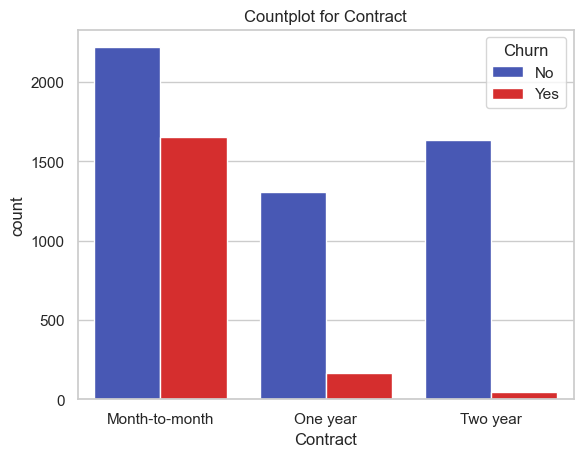

In [7]:
sns.countplot(x='Contract',hue='Churn',data=df,palette={'No': "#364BC6", 'Yes': "#F11212"})
plt.title("Countplot for Contract")
plt.show()

- Insight: Customers on month-to-month contracts show the highest churn, indicating low commitment and making them the most critical group for early retention efforts.

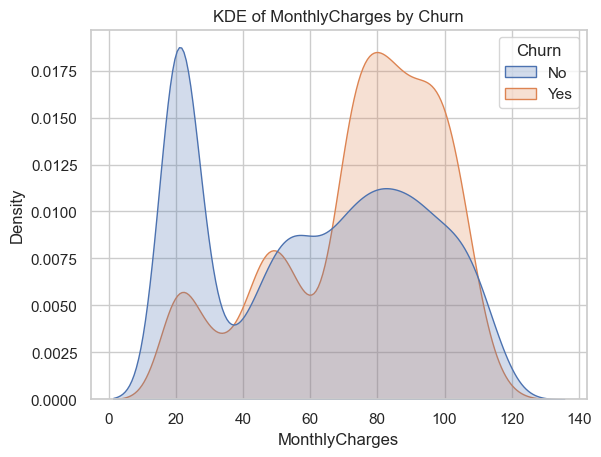

In [8]:
sns.kdeplot(
    data=df,
    x='MonthlyCharges',
    hue='Churn',
    fill=True,
    common_norm=False
)

plt.title("KDE of MonthlyCharges by Churn")
plt.xlabel("MonthlyCharges")
plt.show()

- Insight: Customers with higher monthly charges tend to churn more frequently, suggesting price sensitivity and a possible mismatch between cost and perceived value.

Statistical Analysis

In [9]:
target_column = 'Churn'
independant_col = ['PhoneService','MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
print(f"Testing The realtionship between '{target_column}' and '{independant_col}")

summary_list =[]
for column in independant_col:
    
    clean_df = df[[target_column,column]].dropna()
    contingency_table = pd.crosstab(clean_df[target_column], clean_df[column])
    
    chi2,PVal,dof,expected_freq = chi2_contingency(contingency_table)

    summary_list.append({
       'Feature':column,
       'Chi2 Statistics':round(chi2,2),
       'P Value':round(PVal,4),
       'Association': 'There is Association' if PVal < 0.05 else 'There is no Association'
    })

summary_df = pd.DataFrame(summary_list)
print(summary_df)
   

Testing The realtionship between 'Churn' and '['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
             Feature  Chi2 Statistics  P Value              Association
0       PhoneService             0.87   0.3499  There is no Association
1      MultipleLines            11.27   0.0036     There is Association
2    InternetService           728.70   0.0000     There is Association
3     OnlineSecurity           846.68   0.0000     There is Association
4       OnlineBackup           599.18   0.0000     There is Association
5   DeviceProtection           555.88   0.0000     There is Association
6        TechSupport           824.93   0.0000     There is Association
7        StreamingTV           372.46   0.0000     There is Association
8    StreamingMovies           374.27   0.0000     There is Association
9           Contract         

Most service-related and contract-based features show a statistically significant association with churn, confirming that customer service configuration and payment structure strongly influence churn behavior.

Churn Risk Modeling

In [10]:
df_model = df.copy()
df_model['Churn'] = df_model['Churn'].map({'Yes':1,'No':0})

In [11]:
cat_feature = ['PhoneService','MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport','StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']
num_feature=['MonthlyCharges', 'tenure']

x = df_model[cat_feature + num_feature]
y= df_model['Churn']

x_train,x_test,y_train,y_test = train_test_split(
    x,y,test_size=0.2,random_state=42,stratify=y
)

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feature),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_feature)
])

x_train_final = preprocessor.fit_transform(x_train)
x_test_final = preprocessor.transform(x_test)


In [12]:
smote = SMOTE(random_state=42)

x_train_smote,y_train_smote = smote.fit_resample(
    x_train_final,y_train
)

print(y_train.value_counts())
print(y_train_smote.value_counts())

Churn
0    4130
1    1495
Name: count, dtype: int64
Churn
0    4130
1    4130
Name: count, dtype: int64


In [13]:
log_model_smote = LogisticRegression(max_iter=1000)
log_model_smote.fit(x_train_smote,y_train_smote)

y_pred_log = log_model_smote.predict(x_test_final)

print(classification_report(y_test,y_pred_log))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.80      0.74      0.75      1407



- Interpretation: Logistic regression with SMOTE improves recall for churned customers, making it suitable for identifying at-risk users, though overall precision remains limited.

In [14]:
rf_weighted = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

rf_weighted.fit(x_train_final, y_train)

# Predictions
y_pred_wt = rf_weighted.predict(x_test_final)
y_prob = rf_weighted.predict_proba(x_test_final)[:, 1]

# Evaluation
print(classification_report(y_test, y_pred_wt))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1033
           1       0.57      0.59      0.58       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.71      1407
weighted avg       0.77      0.77      0.77      1407

ROC AUC: 0.8171581137955489


- Interpretation: The class-weighted random forest provides a balanced trade-off between precision and recall, improving churn detection while maintaining reasonable overall accuracy.

In [15]:
rf_smote = Pipeline([
('smote',SMOTE(random_state=42)),
('rf',RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    random_state=42
))
])

In [16]:
rf_smote.fit(x_train_final,y_train)

y_pred_rf = rf_smote.predict(x_test_final)
y_prob = rf_smote.predict_proba(x_test_final)[:,1]

print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1033
           1       0.57      0.61      0.59       374

    accuracy                           0.78      1407
   macro avg       0.71      0.72      0.72      1407
weighted avg       0.78      0.78      0.78      1407



- Interpretation: Applying SMOTE to the random forest slightly improves recall for churned customers, indicating better sensitivity to minority class patterns.

In [17]:
lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

lgbm.fit(x_train_final,y_train)

y_pred_lgbm = lgbm.predict(x_test_final)
y_prob_lgbm = lgbm.predict_proba(x_test_final)[:,1]

print(classification_report(y_test,y_pred_lgbm))
print('Confusion Matrix',confusion_matrix(y_test,y_pred_lgbm))
print("ROC AUC",roc_auc_score(y_test,y_prob_lgbm))

[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.72      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.73      0.70      1407
weighted avg       0.78      0.74      0.75      1407

Confusion Matrix [[774 259]
 [105 269]]
ROC AUC 0.8199108561844168


- Interpretation: LightGBM achieves the best overall performance, particularly in identifying churned customers, making it the most suitable model for churn prediction in this analysis.

Model Evaluation

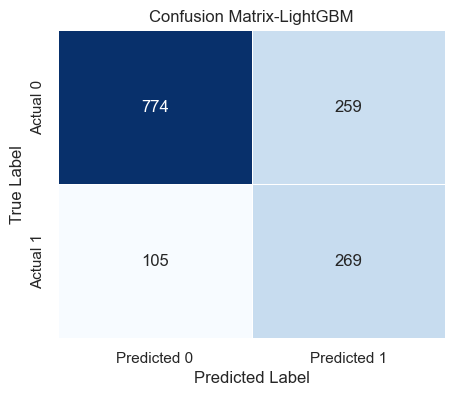

In [18]:
cm_lgbm = confusion_matrix(y_test,y_pred_lgbm)
plt.figure(figsize=(5,4))

sns.heatmap(
    cm_lgbm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    xticklabels=['Predicted 0','Predicted 1'],
    yticklabels=['Actual 0','Actual 1']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix-LightGBM')
plt.show()

- Insight: The model prioritizes identifying churned customers, accepting some false positives, which aligns with business goals where missing a churner is more costly than contacting a loyal customer.

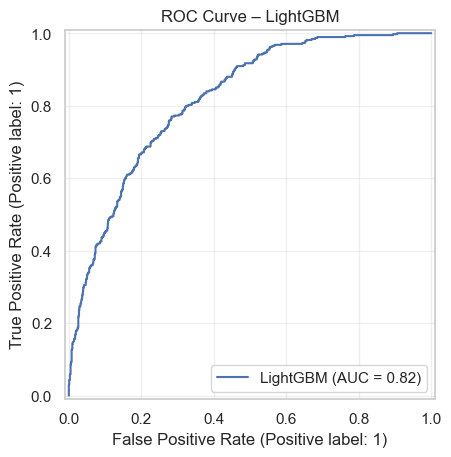

In [19]:
RocCurveDisplay.from_predictions(
    y_test,
    y_prob_lgbm,
    name='LightGBM',
    color='#4C72B0'
)

plt.title('ROC Curve – LightGBM')
plt.grid(alpha=0.3)
plt.show()

- Insight: The ROC curve demonstrates good discriminatory power, with an AUC of around 0.82, indicating that the model can effectively distinguish between churned and non-churned customers across different decision thresholds

Model Interpretation:
While Logistic Regression provides clear interpretability and baseline performance, tree-based models such as Random Forest and LightGBM perform better by capturing non-linear relationships between customer attributes and churn behavior. This makes ensemble models more suitable for identifying high-risk customers, while simpler models remain useful for business explanation.

Key Insights & Business Takeaways:
- Month-to-month contracts are the strongest indicator of customer churn.

- Customers with high monthly charges are more likely to leave, pointing to    pricing sensitivity.

- New customers exhibit higher churn rates compared to long-term customers.

- Additional services appear to reduce churn by increasing customer engagement.

- Predictive models can help prioritize high-risk customers for targeted retention strategies.